In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy as copy
import datetime
import json
from math import ceil
import multiprocessing
import logging
import operator
import os
from pathlib import Path
import random
import sys
import time
import typing
import warnings

import joblib
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.core.numeric import outer
import pandas as pd
from scipy.stats import mode, entropy
import seaborn as sns
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
from sklearn.metrics import roc_auc_score
import sklearn.model_selection
import typer
from tqdm.auto import tqdm

root = str(Path.cwd().parents[1])
sys.path.append(root)
os.chdir(root)
import src

# Scenario A

In [2]:
%%time

X, y, s = src.get_Xys()
y = y>1
ys = y.astype(str) + s.astype(int).astype(str)
skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
folds = list(skf.split(X=X, y=ys))

iterator = [
    (orthogonality, max_depth, fold, train_indices, test_indices) 
    for orthogonality in np.linspace(0, 1, 11)
    for max_depth in np.arange(1, 11)
    for fold, (train_indices, test_indices) in enumerate(folds)
]

results_A = list()

for orthogonality, max_depth, fold, train_indices, test_indices in tqdm(iterator):   
    filepath = f'cache/notebook26/A-{max_depth}-{orthogonality:.1f}-{fold}.pkl'
    
    ships_train = X.iloc[train_indices].index
    ships_test = X.iloc[test_indices].index

    X_train, X_test = X.loc[ships_train], X.loc[ships_test]
    y_train, y_test = y.loc[ships_train], y.loc[ships_test]
    s_train, s_test = s.loc[ships_train], s.loc[ships_test]

    X_train = np.ascontiguousarray(X_train.values)
    y_train = np.ascontiguousarray(y_train.values.ravel())
    s_train = np.ascontiguousarray(s_train.values.ravel())
    X_test = np.ascontiguousarray(X_test.values)
    y_test = np.ascontiguousarray(y_test.values.ravel())
    s_test = np.ascontiguousarray(s_test.values.ravel())

    vt = sklearn.feature_selection.VarianceThreshold()
    vt.fit(X_train)
    X_train = vt.transform(X_train)
    X_test = vt.transform(X_test) 

    if os.path.isfile(filepath):
        clf = joblib.load(filepath)
        fit_time = np.nan
    else:
        clf = src.FairRandomForestClassifier(
            max_depth=max_depth, 
            n_estimators=100, 
            orthogonality=orthogonality, 
            n_jobs=100, 
            n_bins=2
        )    
        start = time.time()
        clf.fit(X_train, y_train, s_train)
        joblib.dump(clf, filepath)
        fit_time = time.time() - start
    y_score = clf.predict_proba(X_test)[:,1]
    auc_y = sklearn.metrics.roc_auc_score(y_true=y_test, y_score=y_score)
    auc_s = sklearn.metrics.roc_auc_score(y_true=s_test, y_score=y_score)
    results_A.append(
        {
            'max_depth': max_depth,
            'orthogonality': orthogonality,
            'fold': fold,
            'auc_y': auc_y,
            'auc_s': auc_s,
            'fit_time': fit_time
        }
    )
joblib.dump(results_A, 'cache/notebook26/results_A.pkl')

  0%|          | 0/550 [00:00<?, ?it/s]

CPU times: user 43min 25s, sys: 16min 8s, total: 59min 33s
Wall time: 6h 45min 24s


['cache/notebook26/results_A.pkl']

In [50]:
results_A = joblib.load('cache/notebook26/results_A.pkl')
data_A = (
    pd.DataFrame(results_A).groupby(['max_depth', 'orthogonality']).agg(
        auc_y_mean=('auc_y', 'mean'),
        auc_y_std=('auc_y', 'std'),
        auc_s_mean=('auc_s', 'mean'),
        auc_s_std=('auc_s', 'std'),
        fit_time_man=('fit_time', 'mean')
    )
    .reset_index()
    .sort_values('auc_y_mean', ascending=False)
    .groupby(['orthogonality'])
    .first()
)
data_A
#data.to_pickle('cache/notebook26/A-data.pkl')

,max_depth,auc_y_mean,auc_y_std,auc_s_mean,auc_s_std,fit_time_man
orthogonality,,,,,,
0.0,6,0.675342,0.012638,0.660363,0.017196,47.624358
0.1,6,0.672104,0.014067,0.652862,0.005426,46.958656
0.2,5,0.670453,0.017741,0.649422,0.011615,39.725996
0.3,5,0.669692,0.021942,0.634702,0.017047,39.068384
0.4,5,0.662158,0.024045,0.612512,0.015363,44.167840
0.5,4,0.648733,0.032631,0.582981,0.011075,35.357045
0.6,3,0.634132,0.027549,0.549119,0.033481,23.937542
0.7,2,0.613224,0.025519,0.522042,0.032857,16.196256
0.8,2,0.602160,0.020128,0.515061,0.033750,16.381288


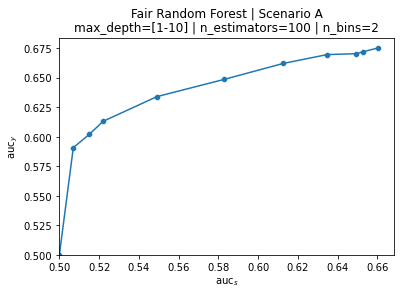

In [51]:
sns.lineplot(data=data_A, x='auc_s_mean', y='auc_y_mean')
sns.scatterplot(data=data_A, x='auc_s_mean', y='auc_y_mean')
plt.xlim(.5)
plt.ylim(.5)
plt.xlabel(r'$\mathrm{auc}_s$')
plt.ylabel(r'$\mathrm{auc}_y$')
plt.title('Fair Random Forest | Scenario A\nmax_depth=[1-10] | n_estimators=100 | n_bins=2')
plt.savefig('fig/26a.png')

In [49]:
(
    pd.DataFrame(results_a)
    .groupby(['max_depth', 'orthogonality'])
    .agg(
        auc_y_mean=('auc_y', 'mean'),
        auc_y_std=('auc_y', 'std'),
        auc_s_mean=('auc_s', 'mean'),
        auc_s_std=('auc_s', 'std'),
        fit_time_mean=('fit_time', 'mean')
    )
    .sort_values('auc_y_mean', ascending=False)
    .reset_index()
)

,max_depth,orthogonality,auc_y_mean,auc_y_std,auc_s_mean,auc_s_std,fit_time_mean
0,6,0.0,0.675342,0.012638,0.660363,0.017196,47.624358
1,6,0.1,0.672104,0.014067,0.652862,0.005426,46.958656
2,5,0.1,0.671198,0.014931,0.655459,0.011307,39.666675
3,5,0.2,0.670453,0.017741,0.649422,0.011615,39.725996
4,5,0.0,0.670240,0.011917,0.660947,0.012642,40.035741
...,...,...,...,...,...,...,...
105,8,0.6,0.413485,0.017007,0.456016,0.037485,66.904536
106,7,0.5,0.407716,0.017682,0.443815,0.020781,65.367464
107,8,0.3,0.405439,0.021524,0.407500,0.031014,78.704700
108,8,0.5,0.403897,0.031932,0.440560,0.027087,72.341191


# Scenario B

In [5]:
%%time

X, y, s = src.get_Xys()
y = y>0
ys = y.astype(str) + s.astype(int).astype(str)
skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
folds = list(skf.split(X=X, y=ys))

iterator = [
    (orthogonality, max_depth, fold, train_indices, test_indices) 
    for orthogonality in np.linspace(0, 1, 11)
    for max_depth in np.arange(1, 11)
    for fold, (train_indices, test_indices) in enumerate(folds)
]

results_B = list()

for orthogonality, max_depth, fold, train_indices, test_indices in tqdm(iterator):   
    filepath = f'cache/notebook26/B-{max_depth}-{orthogonality:.1f}-{fold}.pkl'
    
    ships_train = X.iloc[train_indices].index
    ships_test = X.iloc[test_indices].index

    X_train, X_test = X.loc[ships_train], X.loc[ships_test]
    y_train, y_test = y.loc[ships_train], y.loc[ships_test]
    s_train, s_test = s.loc[ships_train], s.loc[ships_test]

    X_train = np.ascontiguousarray(X_train.values)
    y_train = np.ascontiguousarray(y_train.values.ravel())
    s_train = np.ascontiguousarray(s_train.values.ravel())
    X_test = np.ascontiguousarray(X_test.values)
    y_test = np.ascontiguousarray(y_test.values.ravel())
    s_test = np.ascontiguousarray(s_test.values.ravel())

    vt = sklearn.feature_selection.VarianceThreshold()
    vt.fit(X_train)
    X_train = vt.transform(X_train)
    X_test = vt.transform(X_test) 

    if os.path.isfile(filepath):
        clf = joblib.load(filepath)
        fit_time = np.nan
    else:
        clf = src.FairRandomForestClassifier(
            max_depth=max_depth, 
            n_estimators=100, 
            orthogonality=orthogonality, 
            n_jobs=100, 
            n_bins=2
        )    
        start = time.time()
        clf.fit(X_train, y_train, s_train)
        joblib.dump(clf, filepath)
        fit_time = time.time() - start
    y_score = clf.predict_proba(X_test)[:,1]
    auc_y = sklearn.metrics.roc_auc_score(y_true=y_test, y_score=y_score)
    auc_s = sklearn.metrics.roc_auc_score(y_true=s_test, y_score=y_score)
    results_B.append(
        {
            'max_depth': max_depth,
            'orthogonality': orthogonality,
            'fold': fold,
            'auc_y': auc_y,
            'auc_s': auc_s,
            'fit_time': fit_time
        }
    )
joblib.dump(results_B, 'cache/notebook26/results_B.pkl')

  0%|          | 0/550 [00:00<?, ?it/s]

CPU times: user 46min 21s, sys: 15min 13s, total: 1h 1min 35s
Wall time: 7h 12min 12s


['cache/notebook26/results_B.pkl']

In [54]:
def normalize_auc_s_mean(x):
    return x['auc_s_mean'].where(x['auc_s_mean']>.5, 1-x['auc_s_mean'])

results_B = joblib.load('cache/notebook26/results_B.pkl')

data_B = (
    pd.DataFrame(results_B).groupby(['max_depth', 'orthogonality']).agg(
        auc_y_mean=('auc_y', 'mean'),
        auc_y_std=('auc_y', 'std'),
        auc_s_mean=('auc_s', 'mean'),
        auc_s_std=('auc_s', 'std'),
        fit_time_man=('fit_time', 'mean')
    ).assign(
        auc_s_mean=normalize_auc_s_mean
    )
    .reset_index()
    .sort_values('auc_y_mean', ascending=False)
    .groupby(['orthogonality'])
    .first()
#     .set_index('orthogonality')
#     .loc[lambda x: x['max_depth'] == 6]
)
data_B

,max_depth,auc_y_mean,auc_y_std,auc_s_mean,auc_s_std,fit_time_man
orthogonality,,,,,,
0.0,6,0.814402,0.003850,0.626898,0.013815,48.912627
0.1,6,0.813765,0.003883,0.617525,0.012643,46.334135
0.2,6,0.812861,0.005782,0.607162,0.013119,50.029236
0.3,6,0.806461,0.004506,0.593682,0.010995,50.636370
0.4,5,0.803892,0.006532,0.582603,0.013076,41.464591
0.5,5,0.801250,0.004161,0.569496,0.010762,43.048584
0.6,5,0.789117,0.007203,0.552481,0.014128,40.199031
0.7,4,0.775135,0.009866,0.535433,0.014075,31.644334
0.8,4,0.765933,0.009260,0.528704,0.012540,29.827166


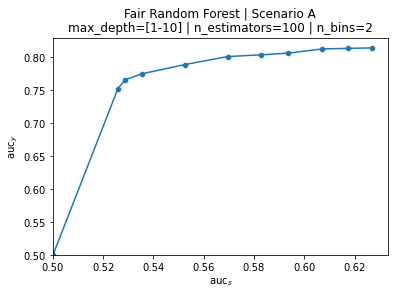

In [55]:
sns.lineplot(data=data_B, x='auc_s_mean', y='auc_y_mean')
sns.scatterplot(data=data_B, x='auc_s_mean', y='auc_y_mean')
plt.xlim(.5)
plt.ylim(.5)
plt.xlabel(r'$\mathrm{auc}_s$')
plt.ylabel(r'$\mathrm{auc}_y$')
plt.title('Fair Random Forest | Scenario A\nmax_depth=[1-10] | n_estimators=100 | n_bins=2')
plt.savefig('fig/26b.png')